# Chapter 2a: Random Forest

This notebook explores Random Forest, a powerful ensemble learning algorithm that builds upon decision trees. We'll cover the mathematical foundation, implementation details, and practical applications of Random Forests for both classification and regression tasks.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_iris, load_breast_cancer, load_wine, fetch_california_housing
from sklearn.inspection import permutation_importance
import joblib
import os

# Configure visualizations
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\aashu\AppData\Local\Temp\ipykernel_9028\216856352.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. Introduction to Random Forest

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mode of the classes (for classification) or mean prediction (for regression) of the individual trees.

### Key Concepts in Random Forest:

1. **Ensemble Learning**: Combining multiple models to improve performance and robustness.
2. **Bagging (Bootstrap Aggregation)**: Training each tree on a random sample with replacement from the training set.
3. **Feature Randomness**: Each tree considers only a random subset of features when determining the best split.
4. **Voting**: Combining predictions through majority voting (classification) or averaging (regression).
5. **Out-of-Bag (OOB) Error**: Error estimate using samples not included in the bootstrap sample for a particular tree.

### Advantages of Random Forest:

- Higher accuracy than individual decision trees
- Reduced risk of overfitting
- Built-in feature importance estimation
- Handles high-dimensional data well
- Maintains accuracy even with missing data
- Inherits many advantages of decision trees (handles categorical features, etc.)

### Disadvantages of Random Forest:

- Less interpretable than single decision trees
- More computationally expensive to train and use
- May overfit on noisy datasets
- Prediction time can be slower than simpler models

## 2. Mathematical Formulation

The Random Forest algorithm introduces randomness in two ways:

1. **Bootstrap Sampling**: For each tree, a random sample of the training data is selected with replacement (bootstrap sample).

   Let $D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$ be the original training data with $n$ samples. For each tree $t$ in the forest, a bootstrap sample $D_t$ is created by sampling $n$ instances from $D$ with replacement.

2. **Random Feature Selection**: At each node of a tree, only a random subset of features is considered for splitting.

   When deciding the best split at each node, only $m_{try}$ features out of the total $M$ features are randomly selected. Typical values for $m_{try}$ are:
   - Classification: $\sqrt{M}$
   - Regression: $M/3$

3. **Aggregation**: The final prediction is made by aggregating the predictions of all trees.
   - Classification: Majority vote
     $C(x) = \text{mode}\{C_1(x), C_2(x), ..., C_T(x)\}$
   - Regression: Average
     $R(x) = \frac{1}{T}\sum_{t=1}^{T} R_t(x)$

   where $T$ is the number of trees, $C_t(x)$ is the class prediction of the $t$-th tree, and $R_t(x)$ is the regression prediction of the $t$-th tree.

4. **Out-of-Bag (OOB) Error Estimation**: For each observation in the original training set, the OOB prediction is calculated using only the trees that did not have this observation in their bootstrap sample.

   The OOB error is the error rate of the OOB predictions compared to the actual values, providing an unbiased estimate of the generalization error.

## 3. Random Forest for Classification

In [2]:
# Load the Breast Cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names
target_names = cancer.target_names

# Print basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature names: {feature_names[:5]}... (and {len(feature_names)-5} more)")
print(f"Target names: {target_names}")

Dataset shape: (569, 30)
Number of classes: 2
Class distribution: [212 357]
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']... (and 25 more)
Target names: ['malignant' 'benign']


In [3]:
# Create a DataFrame for easier data manipulation
cancer_df = pd.DataFrame(X, columns=feature_names)
cancer_df['diagnosis'] = [target_names[i] for i in y]

# Display the first few rows
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


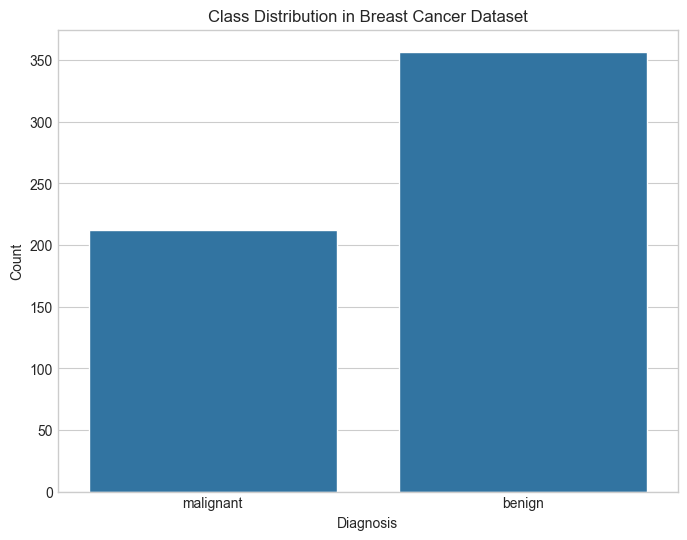

Benign cases: 357 (62.7%)
Malignant cases: 212 (37.3%)


In [4]:
# Explore class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=cancer_df)
plt.title('Class Distribution in Breast Cancer Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

print(f"Benign cases: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"Malignant cases: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")

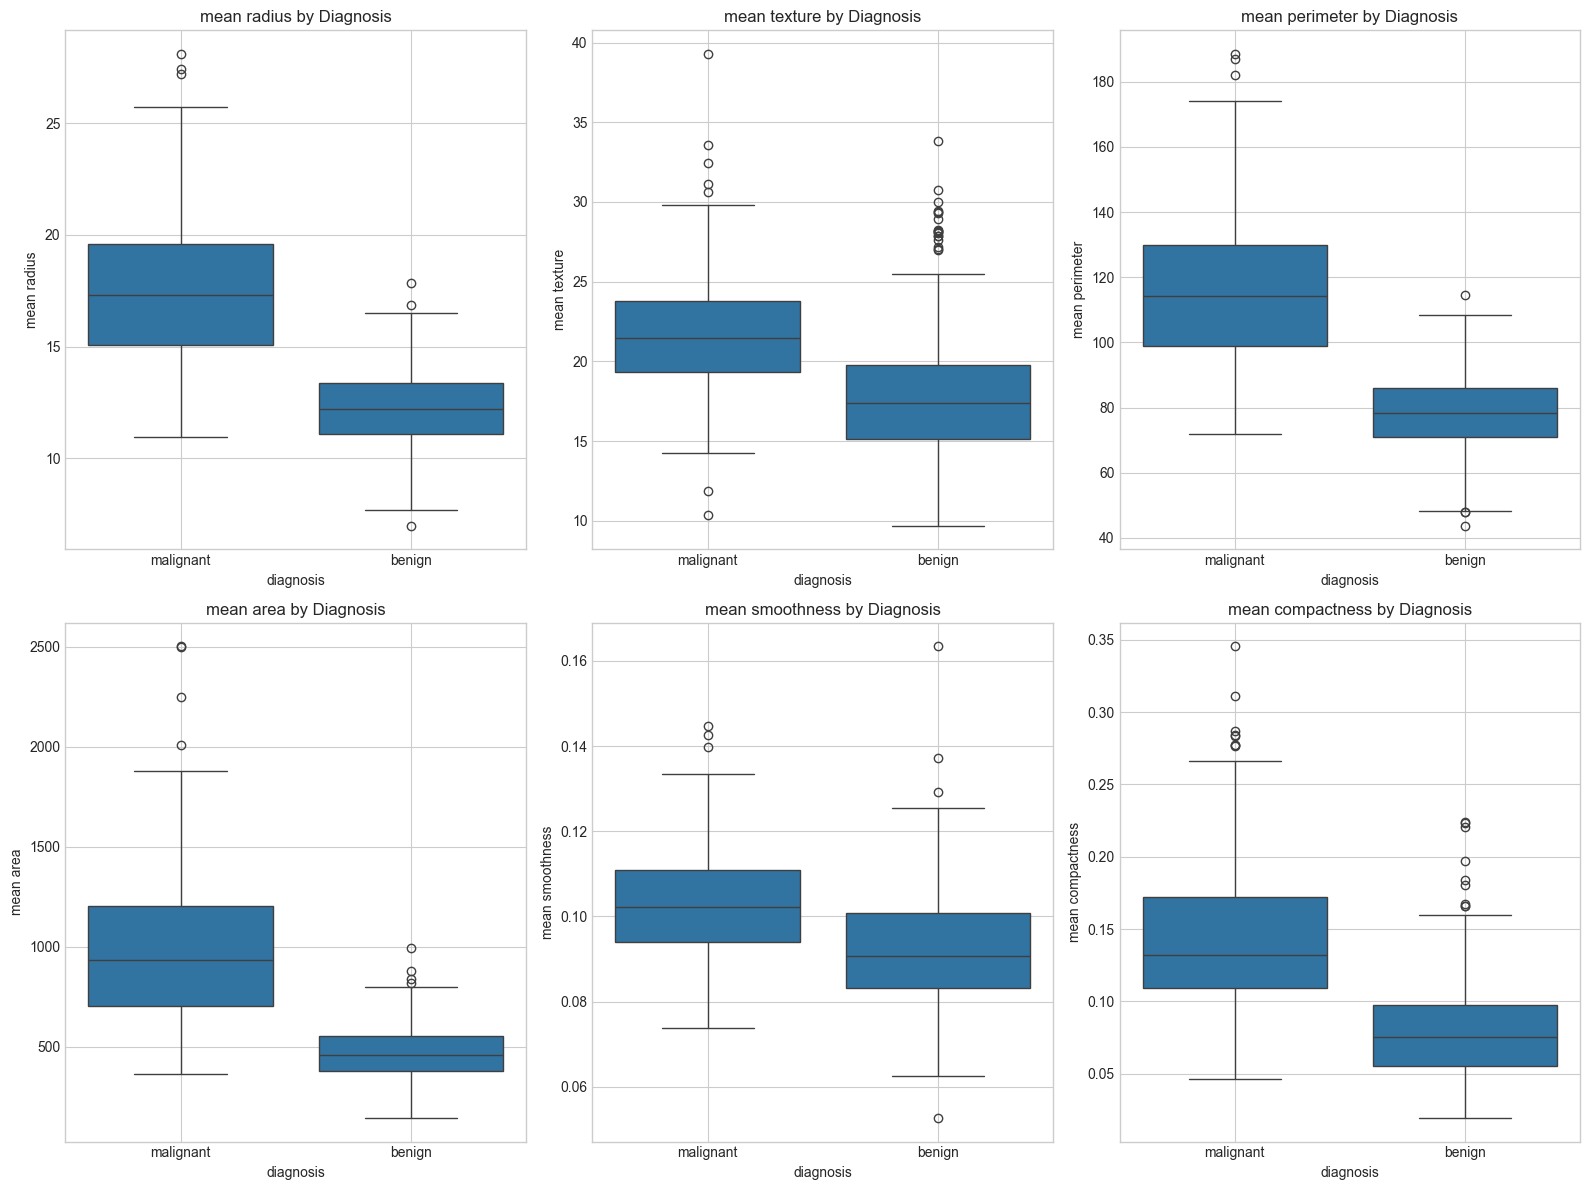

In [5]:
# Visualize a few key features
plt.figure(figsize=(16, 12))

features_to_plot = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness']

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='diagnosis', y=feature, data=cancer_df)
    plt.title(f'{feature} by Diagnosis')
    plt.grid(True)

plt.tight_layout()
plt.show()

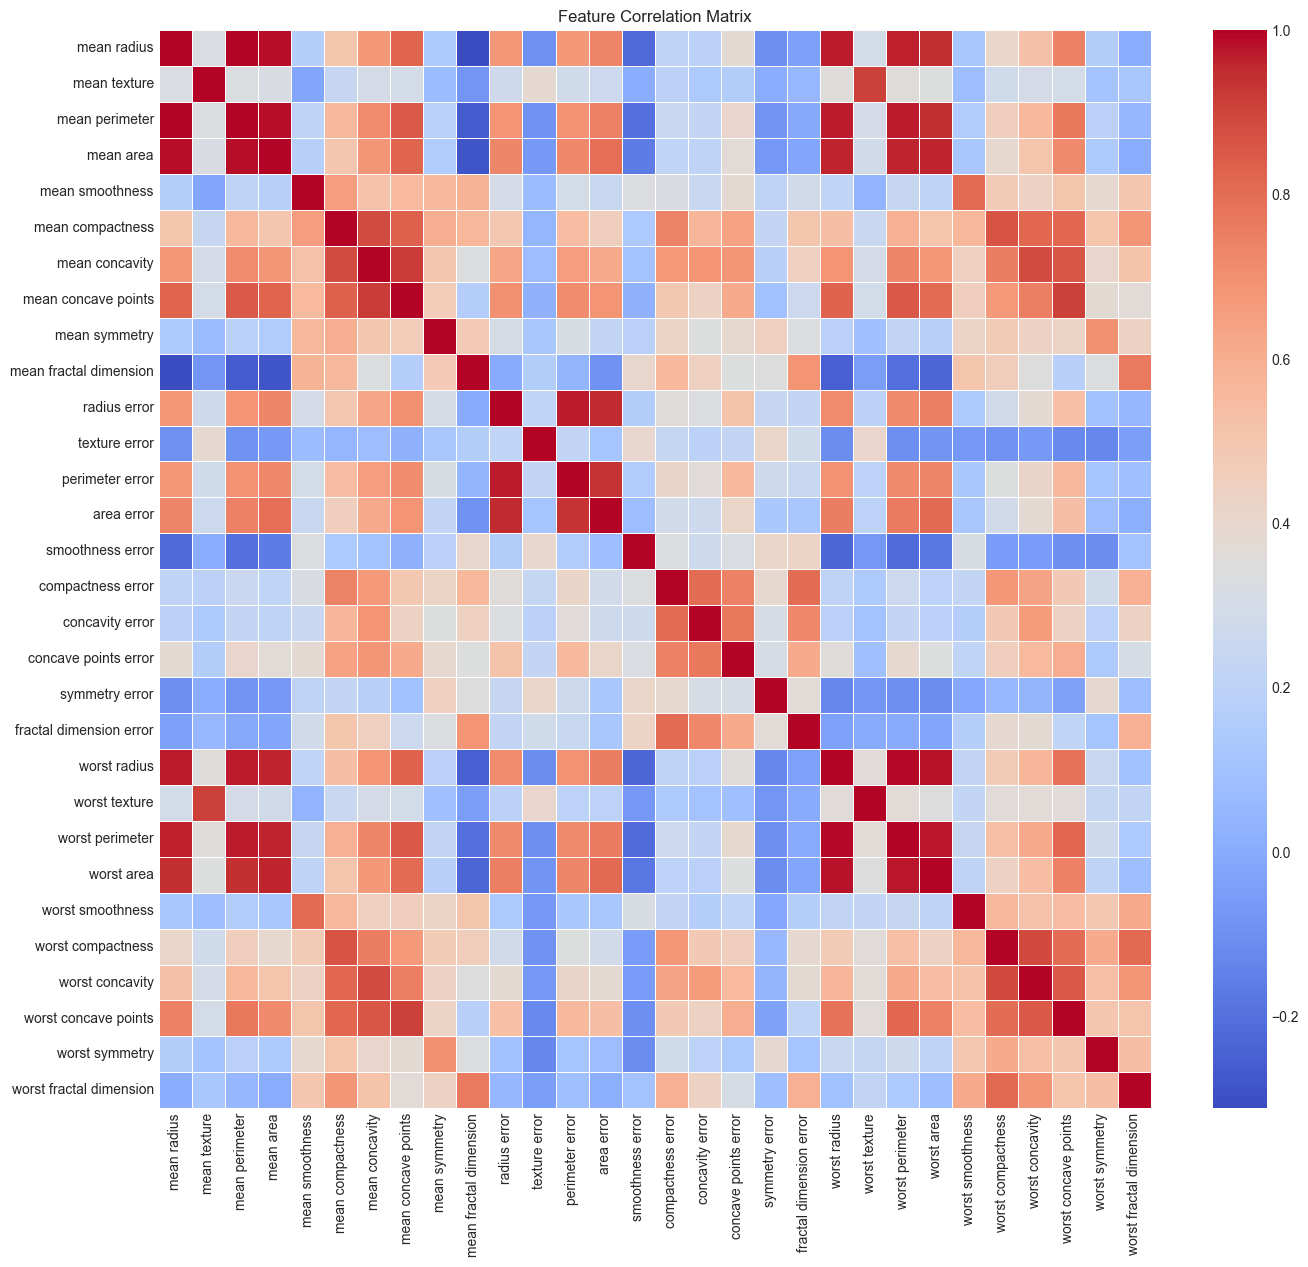

In [6]:
# Check correlation between features
plt.figure(figsize=(16, 14))
correlation = cancer_df.drop('diagnosis', axis=1).corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set shape: (398, 30)
Testing set shape: (171, 30)
Training set class distribution: [148 250]
Testing set class distribution: [ 64 107]


Accuracy: 0.9357

Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



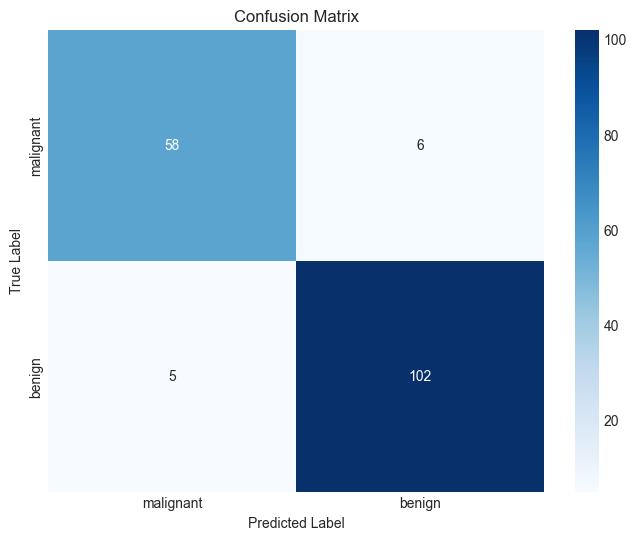

In [8]:
# Train a random forest classifier with default parameters
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_prob = rf_classifier.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

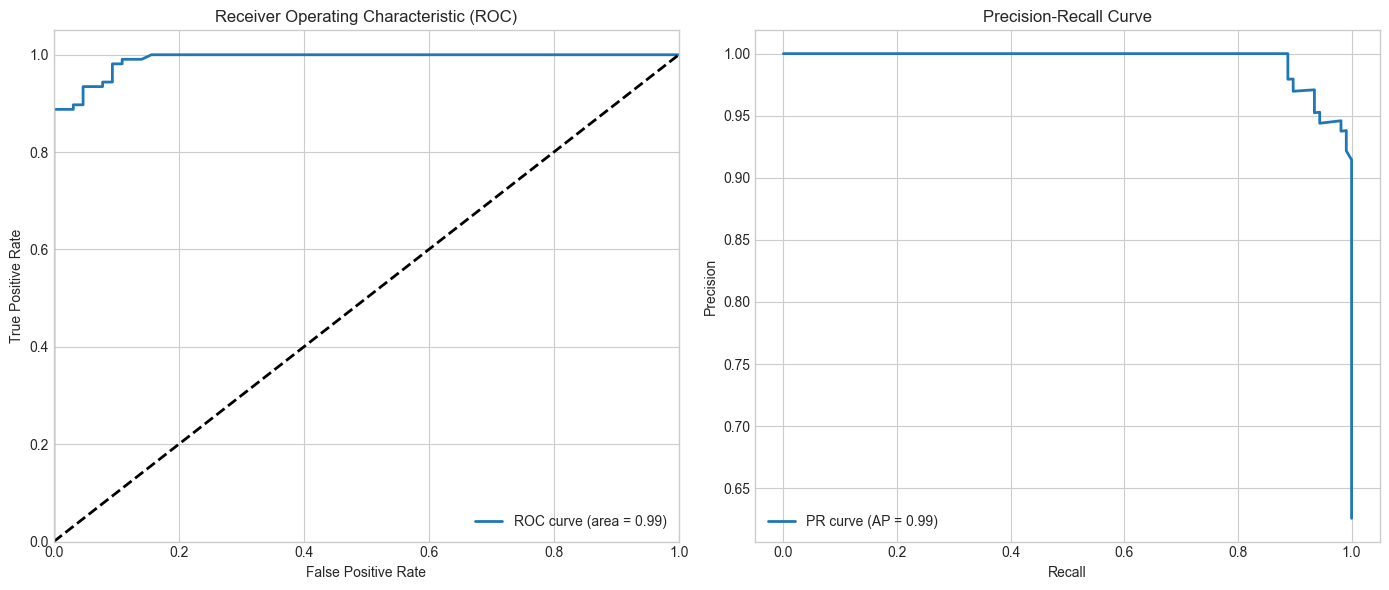

In [9]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

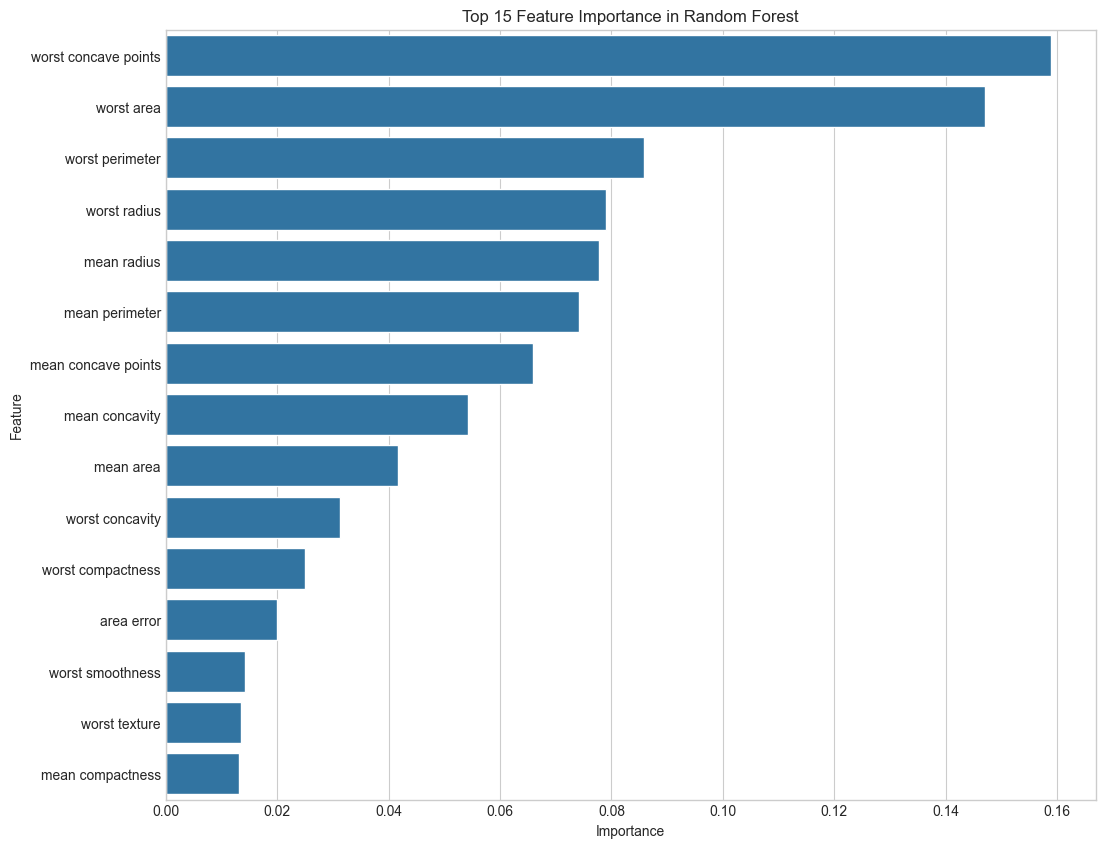

Top 10 Most Important Features:
worst concave points: 0.1590
worst area: 0.1470
worst perimeter: 0.0858
worst radius: 0.0790
mean radius: 0.0777
mean perimeter: 0.0742
mean concave points: 0.0659
mean concavity: 0.0543
mean area: 0.0417
worst concavity: 0.0314


In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Top 10 Most Important Features:")
for index, row in feature_importance.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

### 3.1 Hyperparameter Tuning for Random Forest Classifier

Random Forest has several hyperparameters that can be tuned to improve performance:

- `n_estimators`: The number of trees in the forest
- `max_depth`: The maximum depth of the trees
- `min_samples_split`: The minimum number of samples required to split an internal node
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node
- `max_features`: The number of features to consider when looking for the best split
- `bootstrap`: Whether to use bootstrap samples
- `criterion`: The function to measure the quality of a split (gini or entropy)

Let's use GridSearchCV to find the optimal hyperparameters.

In [11]:
# Define the parameter grid for Random Forest Classifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create a grid search object
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9725


Accuracy with best parameters: 0.9357
Improvement over default parameters: 0.0000

Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



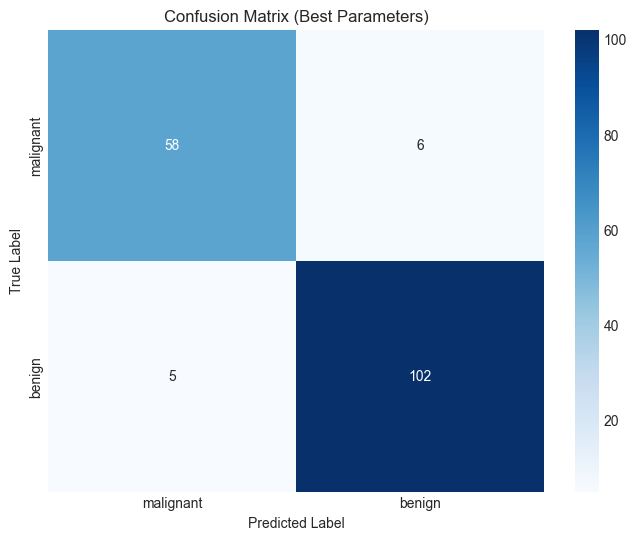

In [12]:
# Train a random forest with the best parameters
best_rf_classifier = grid_search.best_estimator_

# Make predictions
y_pred_best = best_rf_classifier.predict(X_test_scaled)
y_prob_best = best_rf_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy with best parameters: {accuracy_best:.4f}")
print(f"Improvement over default parameters: {accuracy_best - accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=target_names))

# Confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Best Parameters)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

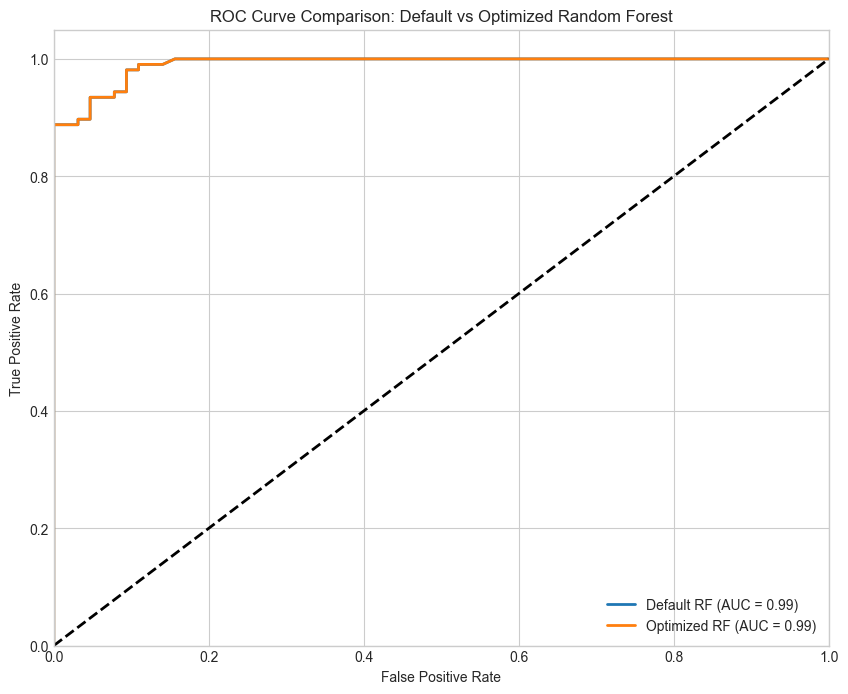

In [13]:
# Calculate ROC curve and AUC for the optimized model
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Plot both ROC curves for comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f'Default RF (AUC = {roc_auc:.2f})')
plt.plot(fpr_best, tpr_best, lw=2, label=f'Optimized RF (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Default vs Optimized Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

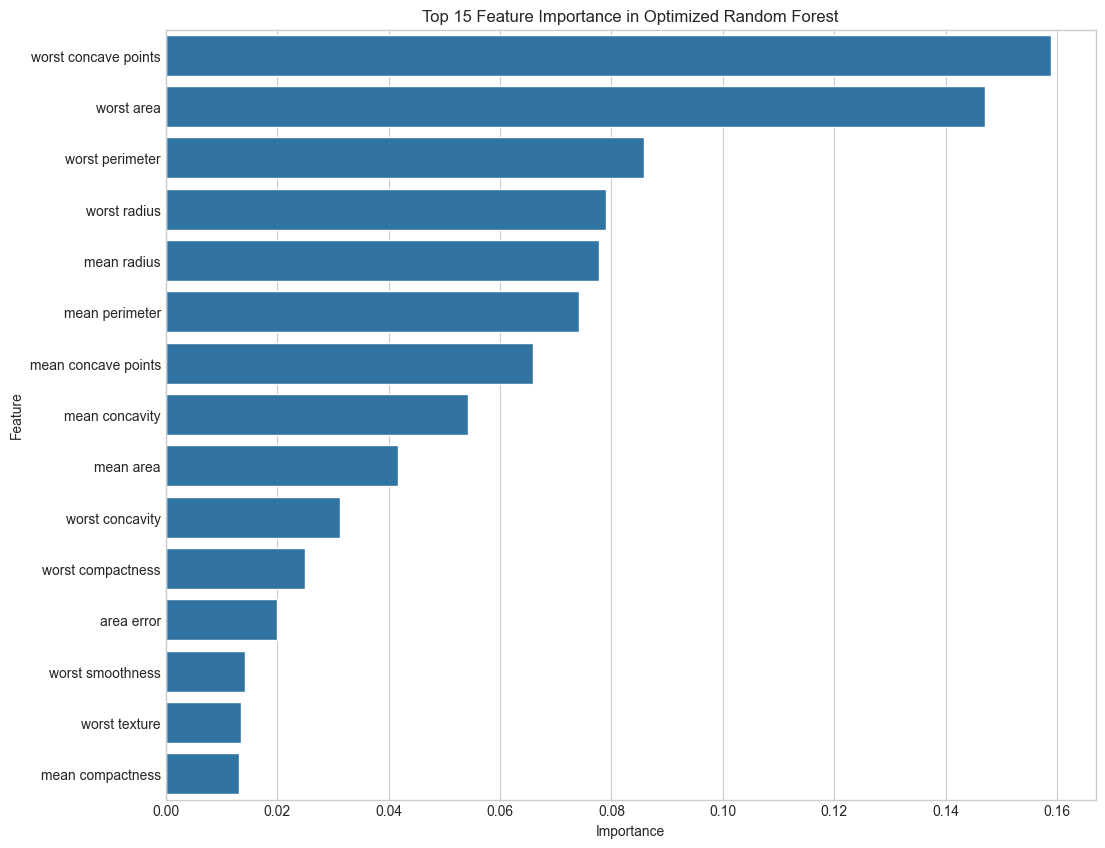

Top 10 Most Important Features:
worst concave points: 0.1590
worst area: 0.1470
worst perimeter: 0.0858
worst radius: 0.0790
mean radius: 0.0777
mean perimeter: 0.0742
mean concave points: 0.0659
mean concavity: 0.0543
mean area: 0.0417
worst concavity: 0.0314


In [14]:
# Feature importance with optimized model
feature_importance_best = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_best.head(15))
plt.title('Top 15 Feature Importance in Optimized Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Top 10 Most Important Features:")
for index, row in feature_importance_best.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

### 3.2 Multi-class Classification with Random Forest

Let's apply Random Forest to a multi-class classification problem using the Wine dataset.

In [15]:
# Load the Wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
wine_feature_names = wine.feature_names
wine_target_names = wine.target_names

# Print basic information
print(f"Dataset shape: {X_wine.shape}")
print(f"Number of classes: {len(np.unique(y_wine))}")
print(f"Class distribution: {np.bincount(y_wine)}")
print(f"Feature names: {wine_feature_names}")
print(f"Target names: {wine_target_names}")

Dataset shape: (178, 13)
Number of classes: 3
Class distribution: [59 71 48]
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']


In [16]:
# Split the data
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

# Standardize the features
scaler_wine = StandardScaler()
X_train_wine_scaled = scaler_wine.fit_transform(X_train_wine)
X_test_wine_scaled = scaler_wine.transform(X_test_wine)

print(f"Training set shape: {X_train_wine.shape}")
print(f"Testing set shape: {X_test_wine.shape}")
print(f"Training set class distribution: {np.bincount(y_train_wine)}")
print(f"Testing set class distribution: {np.bincount(y_test_wine)}")

Training set shape: (124, 13)
Testing set shape: (54, 13)
Training set class distribution: [41 50 33]
Testing set class distribution: [18 21 15]


Accuracy on Wine dataset: 1.0000

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      1.00      1.00        21
     class_2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



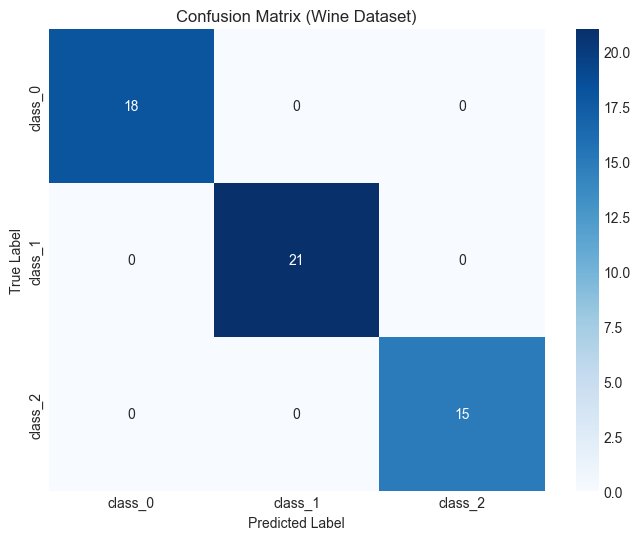

In [17]:
# Train a Random Forest classifier for the wine dataset
rf_wine = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
rf_wine.fit(X_train_wine_scaled, y_train_wine)

# Make predictions
y_pred_wine = rf_wine.predict(X_test_wine_scaled)

# Evaluate the model
wine_accuracy = accuracy_score(y_test_wine, y_pred_wine)
print(f"Accuracy on Wine dataset: {wine_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_wine, y_pred_wine, target_names=wine_target_names))

# Confusion matrix
wine_conf_matrix = confusion_matrix(y_test_wine, y_pred_wine)
plt.figure(figsize=(8, 6))
sns.heatmap(wine_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=wine_target_names, yticklabels=wine_target_names)
plt.title('Confusion Matrix (Wine Dataset)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

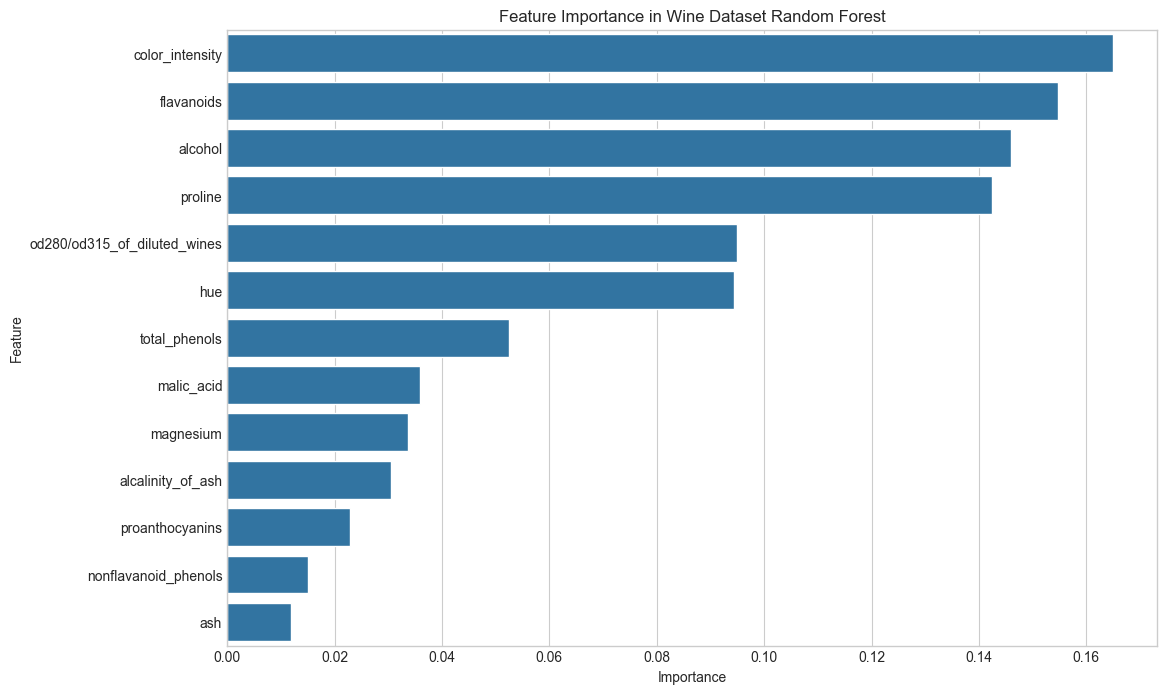

Top 5 Most Important Features:
color_intensity: 0.1649
flavanoids: 0.1547
alcohol: 0.1460
proline: 0.1425
od280/od315_of_diluted_wines: 0.0949


In [18]:
# Feature importance for Wine dataset
wine_feature_importance = pd.DataFrame({
    'Feature': wine_feature_names,
    'Importance': rf_wine.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=wine_feature_importance)
plt.title('Feature Importance in Wine Dataset Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Top 5 Most Important Features:")
for index, row in wine_feature_importance.head(5).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

## 4. Random Forest for Regression

In [19]:
# Load the California Housing dataset
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target
housing_feature_names = housing.feature_names

# Print basic information
print(f"Dataset shape: {X_housing.shape}")
print(f"Target range: {y_housing.min():.2f} to {y_housing.max():.2f}")
print(f"Target mean: {y_housing.mean():.2f}")
print(f"Feature names: {housing_feature_names}")

Dataset shape: (20640, 8)
Target range: 0.15 to 5.00
Target mean: 2.07
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [20]:
# Split the data
X_train_housing, X_test_housing, y_train_housing, y_test_housing = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# Standardize the features
scaler_housing = StandardScaler()
X_train_housing_scaled = scaler_housing.fit_transform(X_train_housing)
X_test_housing_scaled = scaler_housing.transform(X_test_housing)

print(f"Training set shape: {X_train_housing.shape}")
print(f"Testing set shape: {X_test_housing.shape}")

Training set shape: (16512, 8)
Testing set shape: (4128, 8)


In [21]:
# Train a Random Forest regressor with default parameters
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_housing_scaled, y_train_housing)

# Make predictions
y_pred_housing = rf_regressor.predict(X_test_housing_scaled)

# Evaluate the model
mse = mean_squared_error(y_test_housing, y_pred_housing)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_housing, y_pred_housing)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.2552
Root Mean Squared Error: 0.5051
R² Score: 0.8053


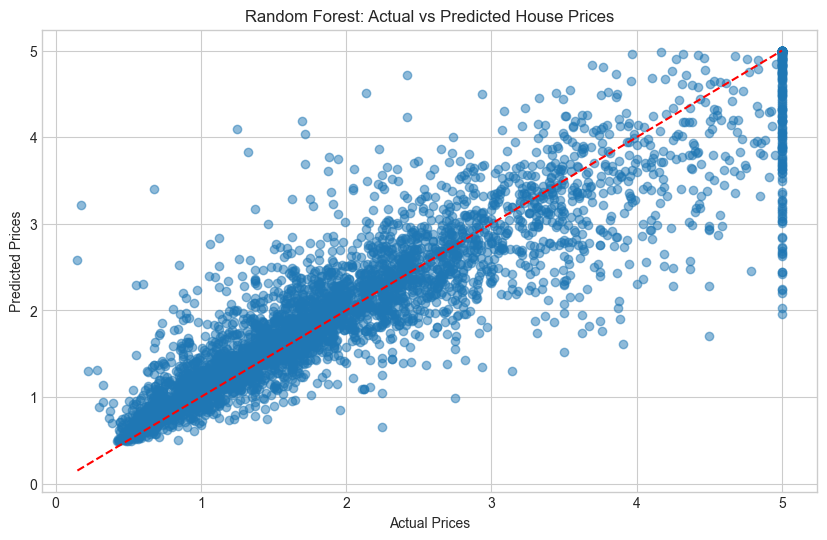

In [22]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_housing, y_pred_housing, alpha=0.5)
plt.plot([y_test_housing.min(), y_test_housing.max()], [y_test_housing.min(), y_test_housing.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted House Prices')
plt.grid(True)
plt.show()

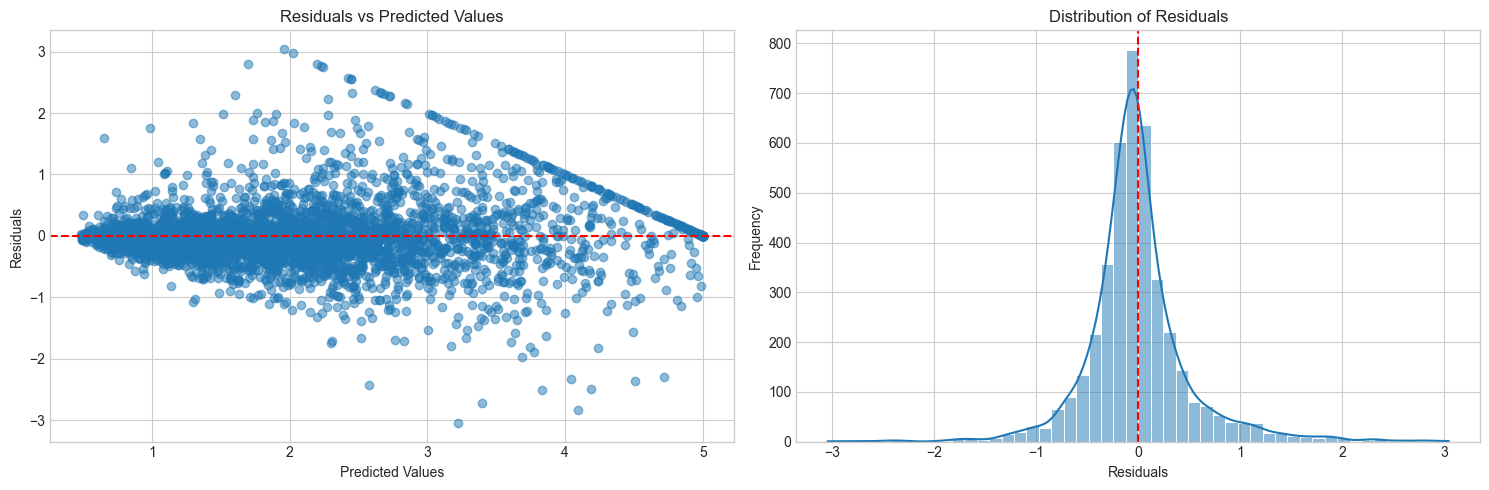

Mean of residuals: -0.0125
Standard deviation of residuals: 0.5050


In [23]:
# Analyze residuals
residuals = y_test_housing - y_pred_housing

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_housing, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Standard deviation of residuals: {residuals.std():.4f}")

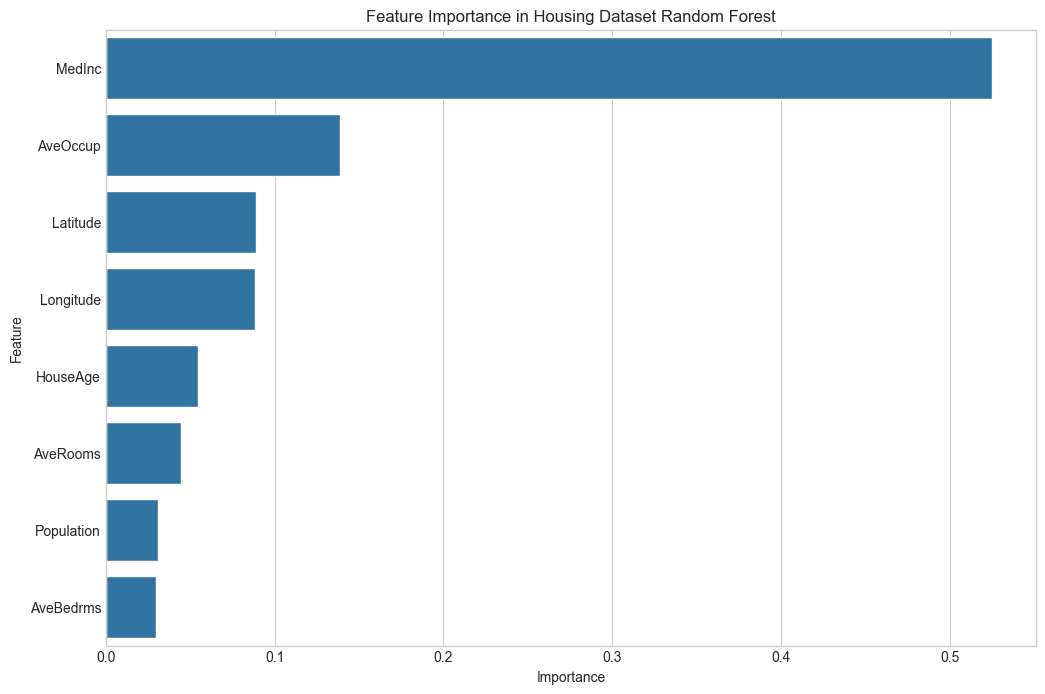

Feature Importance:
MedInc: 0.5249
AveOccup: 0.1384
Latitude: 0.0889
Longitude: 0.0886
HouseAge: 0.0546
AveRooms: 0.0443
Population: 0.0306
AveBedrms: 0.0296


In [24]:
# Feature importance for regression
housing_feature_importance = pd.DataFrame({
    'Feature': housing_feature_names,
    'Importance': rf_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=housing_feature_importance)
plt.title('Feature Importance in Housing Dataset Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Feature Importance:")
for index, row in housing_feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

### 4.1 Hyperparameter Tuning for Random Forest Regressor

In [25]:
# Define the parameter grid for Random Forest Regressor
# Using a smaller subset for faster tuning
indices = np.random.choice(X_train_housing_scaled.shape[0], 10000, replace=False)
X_train_housing_subset = X_train_housing_scaled[indices]
y_train_housing_subset = y_train_housing[indices]

param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2']
}

# Create a grid search object
grid_search_reg = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_reg,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search_reg.fit(X_train_housing_subset, y_train_housing_subset)

# Print the best parameters and best score
print(f"Best parameters: {grid_search_reg.best_params_}")
print(f"Best cross-validation MSE: {-grid_search_reg.best_score_:.4f}")
print(f"Best cross-validation RMSE: {np.sqrt(-grid_search_reg.best_score_):.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation MSE: 0.2661
Best cross-validation RMSE: 0.5159


In [26]:
# Train a Random Forest regressor with the best parameters
best_rf_regressor = RandomForestRegressor(
    n_estimators=grid_search_reg.best_params_['n_estimators'],
    max_depth=grid_search_reg.best_params_['max_depth'],
    min_samples_split=grid_search_reg.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_reg.best_params_['min_samples_leaf'],
    max_features=grid_search_reg.best_params_['max_features'],
    random_state=42
)

# Train on the full training set
best_rf_regressor.fit(X_train_housing_scaled, y_train_housing)

# Make predictions
y_pred_housing_best = best_rf_regressor.predict(X_test_housing_scaled)

# Evaluate the model
mse_best = mean_squared_error(y_test_housing, y_pred_housing_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_housing, y_pred_housing_best)

print(f"Mean Squared Error with best parameters: {mse_best:.4f}")
print(f"Root Mean Squared Error with best parameters: {rmse_best:.4f}")
print(f"R² Score with best parameters: {r2_best:.4f}")

print(f"\nImprovement in MSE: {mse - mse_best:.4f}")
print(f"Improvement in RMSE: {rmse - rmse_best:.4f}")
print(f"Improvement in R²: {r2_best - r2:.4f}")

Mean Squared Error with best parameters: 0.2434
Root Mean Squared Error with best parameters: 0.4934
R² Score with best parameters: 0.8143

Improvement in MSE: 0.0118
Improvement in RMSE: 0.0118
Improvement in R²: 0.0090


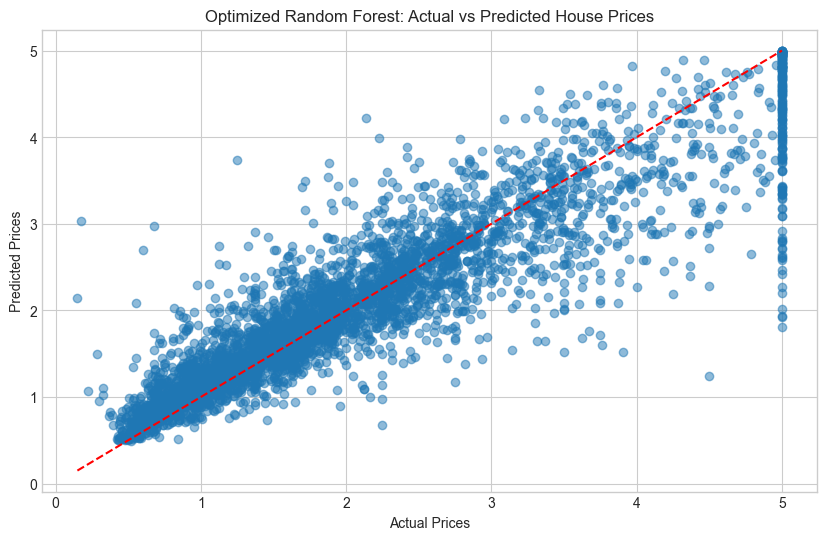

In [27]:
# Visualize actual vs predicted values with optimized model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_housing, y_pred_housing_best, alpha=0.5)
plt.plot([y_test_housing.min(), y_test_housing.max()], [y_test_housing.min(), y_test_housing.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Optimized Random Forest: Actual vs Predicted House Prices')
plt.grid(True)
plt.show()

## 5. Out-of-Bag Error Estimation

One of the advantages of Random Forest is the ability to estimate the error using out-of-bag (OOB) samples without the need for a separate validation set.

In [28]:
# Train a Random Forest classifier with OOB score enabled
rf_oob = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42
)

rf_oob.fit(X_train_scaled, y_train)

# Print OOB score
print(f"Out-of-Bag Accuracy: {rf_oob.oob_score_:.4f}")

# Compare with test set performance
y_pred_oob = rf_oob.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_oob)
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Difference: {abs(rf_oob.oob_score_ - test_accuracy):.4f}")

Out-of-Bag Accuracy: 0.9673
Test Set Accuracy: 0.9415
Difference: 0.0258


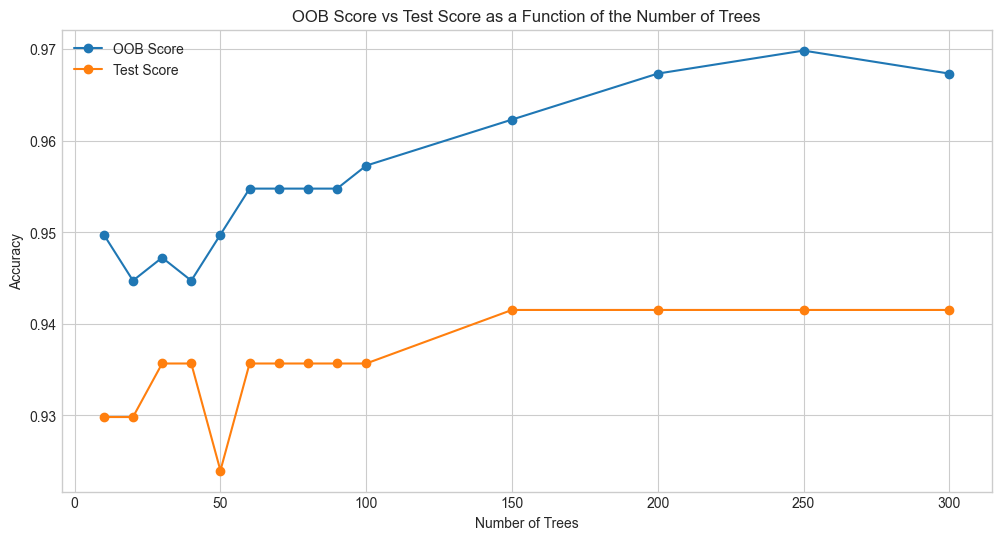

In [29]:
# Evaluate the effect of the number of trees on OOB error
n_estimators_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
oob_scores = []
test_scores = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        oob_score=True,
        random_state=42
    )
    rf.fit(X_train_scaled, y_train)
    oob_scores.append(rf.oob_score_)
    test_scores.append(accuracy_score(y_test, rf.predict(X_test_scaled)))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_list, oob_scores, 'o-', label='OOB Score')
plt.plot(n_estimators_list, test_scores, 'o-', label='Test Score')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('OOB Score vs Test Score as a Function of the Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

## 6. Permutation Feature Importance

While the built-in feature importance in Random Forest is useful, it can sometimes be biased toward high cardinality features. Permutation feature importance is an alternative that measures the decrease in model performance when a feature is randomly shuffled.

StopIteration: 

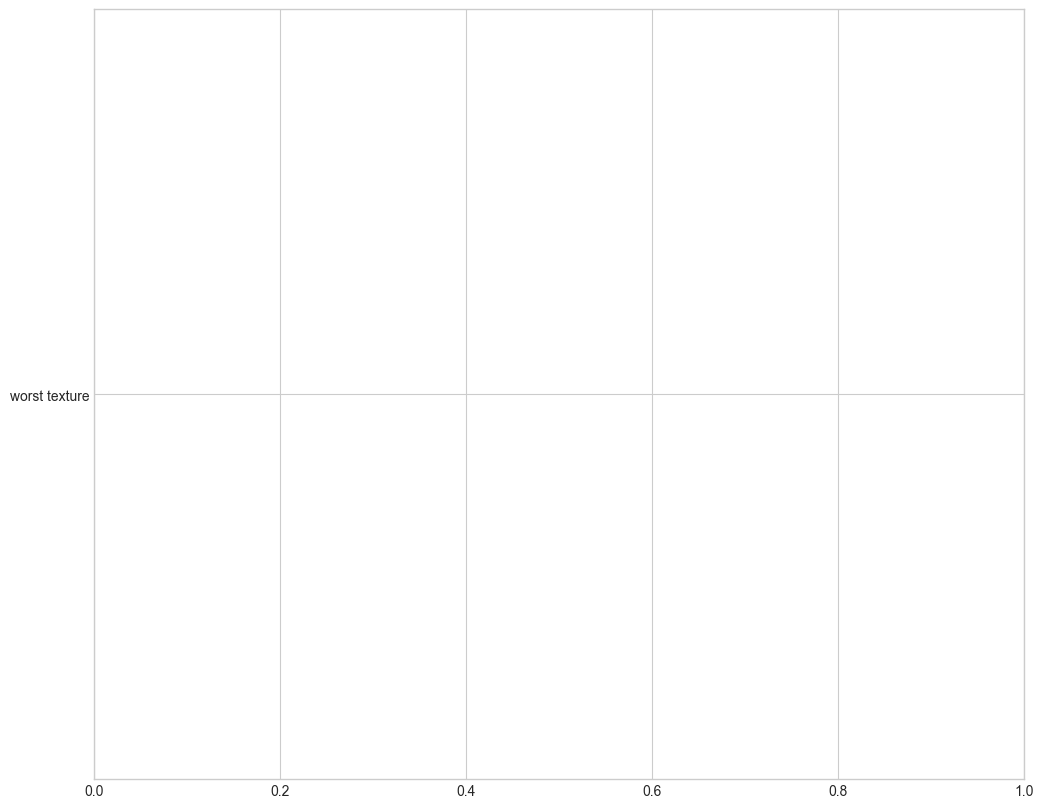

In [30]:
# Calculate permutation feature importance
perm_importance = permutation_importance(
    best_rf_classifier, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Create a DataFrame with the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15), xerr=perm_importance_df['Std'].head(15))
plt.title('Permutation Feature Importance (Top 15)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Top 10 Features by Permutation Importance:")
for index, row in perm_importance_df.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f} ± {row['Std']:.4f}")

In [ ]:
# Compare permutation importance with built-in feature importance
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'Built-in Importance': best_rf_classifier.feature_importances_,
    'Permutation Importance': perm_importance.importances_mean
})

# Calculate ranks for both methods
comparison_df['Built-in Rank'] = comparison_df['Built-in Importance'].rank(ascending=False)
comparison_df['Permutation Rank'] = comparison_df['Permutation Importance'].rank(ascending=False)
comparison_df['Rank Difference'] = abs(comparison_df['Built-in Rank'] - comparison_df['Permutation Rank'])

# Sort by the largest rank differences
comparison_df = comparison_df.sort_values('Rank Difference', ascending=False)

# Display the features with the largest rank differences
print("Features with Largest Rank Differences Between Importance Methods:")
print(comparison_df.head(10))

## 7. Cross-Validation Analysis

In [ ]:
# Cross-validation for classification (Breast Cancer dataset)
cv_scores = cross_val_score(
    RandomForestClassifier(**grid_search.best_params_, random_state=42),
    X, y, cv=10, scoring='accuracy'
)

print("Cross-validation scores for Breast Cancer Classification:")
print(f"Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

In [ ]:
# Learning curve for Random Forest classifier
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(**grid_search.best_params_, random_state=42),
    X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Random Forest Learning Curve (Breast Cancer Dataset)")
plt.legend(loc="best")
plt.ylim(0.8, 1.01)
plt.show()

## 8. Comparison with Decision Trees

Let's compare the performance of Random Forest with a single Decision Tree on the same datasets.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# For Classification (Breast Cancer)
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)
dt_pred = dt_classifier.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, dt_pred)

# For Regression (California Housing)
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_housing_scaled, y_train_housing)
dt_pred_housing = dt_regressor.predict(X_test_housing_scaled)
dt_mse = mean_squared_error(y_test_housing, dt_pred_housing)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test_housing, dt_pred_housing)

# Print comparison results
print("Classification Performance Comparison:")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Accuracy: {accuracy_best:.4f}")
print(f"Improvement: {accuracy_best - dt_accuracy:.4f}")

print("\nRegression Performance Comparison:")
print(f"Decision Tree RMSE: {dt_rmse:.4f}")
print(f"Random Forest RMSE: {rmse_best:.4f}")
print(f"Improvement: {dt_rmse - rmse_best:.4f}")
print(f"Decision Tree R²: {dt_r2:.4f}")
print(f"Random Forest R²: {r2_best:.4f}")
print(f"Improvement: {r2_best - dt_r2:.4f}")

In [ ]:
# Visualize classification performance comparison
models = ['Decision Tree', 'Random Forest']
accuracies = [dt_accuracy, accuracy_best]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Classification Accuracy: Decision Tree vs Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0.90, 1.0) # Adjusted to better show differences
plt.grid(True, axis='y')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center')
plt.show()

In [ ]:
# Visualize regression performance comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=[dt_rmse, rmse_best])
plt.title('RMSE: Decision Tree vs Random Forest')
plt.ylabel('RMSE (lower is better)')
plt.grid(True, axis='y')
plt.text(0, dt_rmse + 0.02, f"{dt_rmse:.4f}", ha='center')
plt.text(1, rmse_best + 0.02, f"{rmse_best:.4f}", ha='center')

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=[dt_r2, r2_best])
plt.title('R²: Decision Tree vs Random Forest')
plt.ylabel('R² (higher is better)')
plt.grid(True, axis='y')
plt.text(0, dt_r2 + 0.02, f"{dt_r2:.4f}", ha='center')
plt.text(1, r2_best + 0.02, f"{r2_best:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 9. Model Serialization

Let's save our trained Random Forest models for later use.

In [ ]:
# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the classification model
joblib.dump(best_rf_classifier, 'models/rf_classifier.pkl')

# Save the regression model
joblib.dump(best_rf_regressor, 'models/rf_regressor.pkl')

# Save the scalers
joblib.dump(scaler, 'models/cancer_scaler.pkl')
joblib.dump(scaler_housing, 'models/housing_rf_scaler.pkl')

print("Models and scalers successfully saved to 'models' directory.")

In [ ]:
# Load the saved models to verify
loaded_rf_classifier = joblib.load('models/rf_classifier.pkl')
loaded_rf_regressor = joblib.load('models/rf_regressor.pkl')
loaded_scaler = joblib.load('models/cancer_scaler.pkl')
loaded_housing_scaler = joblib.load('models/housing_rf_scaler.pkl')

# Verify the loaded models work correctly
# Classification
cancer_pred = loaded_rf_classifier.predict(loaded_scaler.transform(X_test))
cancer_accuracy = accuracy_score(y_test, cancer_pred)
print(f"Loaded classification model accuracy: {cancer_accuracy:.4f}")

# Regression
housing_pred = loaded_rf_regressor.predict(loaded_housing_scaler.transform(X_test_housing))
housing_rmse = np.sqrt(mean_squared_error(y_test_housing, housing_pred))
print(f"Loaded regression model RMSE: {housing_rmse:.4f}")

## 10. Chapter Summary

In this chapter, we explored Random Forest, a powerful ensemble learning method that combines multiple decision trees to improve prediction accuracy and robustness:

1. **Theory and Mathematical Concepts**:
   - Ensemble learning principles
   - Bootstrap aggregation (bagging)
   - Random feature selection
   - Out-of-bag error estimation

2. **Classification with Random Forest**:
   - Implementation on the Breast Cancer dataset
   - Feature importance analysis
   - Hyperparameter tuning and grid search
   - Application to the Wine dataset for multi-class classification

3. **Regression with Random Forest**:
   - Implementation on the California Housing dataset
   - Error analysis and visualization
   - Hyperparameter optimization

4. **Advanced Random Forest Techniques**:
   - Out-of-bag error estimation
   - Permutation feature importance
   - Comparison with single decision trees

5. **Model Evaluation and Validation**:
   - Cross-validation
   - Learning curves
   - Performance comparison

6. **Model Serialization**:
   - Saving and loading trained models for later use

Random Forest addresses many limitations of single decision trees, particularly by reducing overfitting and improving prediction accuracy. Key findings include:

- Random Forest consistently outperformed single decision trees in both classification and regression tasks.
- The ensemble approach significantly reduced model variance and improved generalization.
- Feature importance analysis provided valuable insights into the most relevant predictors.
- Hyperparameter tuning further enhanced model performance, though even default parameters yielded strong results.
- Out-of-bag error estimation provided a reliable gauge of model performance without requiring a separate validation set.

Random Forest is a versatile algorithm suitable for a wide range of applications, offering a good balance between model performance, robustness, and ease of use.

## 11. Next Steps

In the next notebook, we'll explore Bayesian classifiers:

1. **Naive Bayes**: Probabilistic classifiers based on Bayes' theorem with strong independence assumptions
2. **Bayesian Networks**: More complex probabilistic graphical models representing conditional dependencies
3. **Gaussian Discriminant Analysis**: Methods like LDA and QDA for classification
4. **Probabilistic Interpretation**: How to interpret model outputs as probabilities